# Drift correction

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

In [1]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [2]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-0.5
    end = np.max(t2)+0.5
    idx = (t1>=start)*(t1<=end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=18)
        
        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        print(thetimes[0:4])
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-1], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [54]:
posfile = "/mnt/documents/Q1/P4-10032021/gnss/stn1_base3/kppp-rtklib/AeN-Q1-P4-S1.pos"

In [55]:
plon, plat, ptimes = readbasegps(posfile)

['2021/03/10 07:10:06.000' '2021/03/10 07:10:06.500'
 '2021/03/10 07:10:07.000' '2021/03/10 07:10:07.500']


In [56]:
ptimes[0]

datetime.datetime(2021, 3, 10, 7, 10, 6)

In [57]:
ptimes[-1]

datetime.datetime(2021, 3, 10, 13, 46, 49)

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to UTM (or other projected system measured in meters)

In [58]:
## get the UTM zone
utmzone=getutm(plon[0], plat[0])
utmzone

[CRSInfo(auth_name='EPSG', code='32636', name='WGS 84 / UTM zone 36N', type=<PJType.PROJECTED_CRS: 'PROJECTED_CRS'>, deprecated=False, area_of_use=AreaOfUse(west=30.0, south=0.0, east=36.0, north=84.0, name='Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.'), projection_method_name='Transverse Mercator')]


'32636'

In [59]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [60]:
gnssutm = thetransform.transform(plat, plon)
gnssutm

(array([1089051.70706358, 1089052.49957829, 1089052.47867142, ...,
        1089665.51946343, 1089665.60076841, 1089665.65474684]),
 array([-218537.03956885, -218536.35700528, -218536.4118124 , ...,
        -218802.19420296, -218802.21403076, -218802.22356369]))

## Convert time to seconds-of-day

**check time zones! Use UTC.**

In [63]:
gnssdayseconds=[]
for thetime in ptimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))
    
gnssdayseconds = np.array(gnssdayseconds)

In [64]:
gnssdayseconds[0:5]

array([25806. , 25806.5, 25807. , 25807.5, 25808. ])

## Load  GEM2 data to be drift corrected

In [ ]:
gem2inputfile = "/mnt/documents/Q1/P4-10032021/GEM2/Q1-P4-transect-11032021-gem2-531-channel-thickness.csv"

In [ ]:
gem2data = pd.read_csv(gem2inputfile)

In [ ]:
gem2data

In [ ]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [ ]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [ ]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [ ]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

In [ ]:
gem2easting[0]

In [ ]:
plt.scatter(gem2easting-np.min(gem2easting), gem2northing-min(gem2northing), c = f1530hz_hcp_i)
plt.title("uncorrected drift track - local coordinates")

In [ ]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [ ]:
gem2dayseconds = np.round(gem2dayseconds, 4)

In [ ]:
gem2dayseconds

In [ ]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

In [ ]:
gnssdayseconds = np.array(gnssdayseconds)

In [ ]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [ ]:
trimmedtime.size

In [ ]:
timesteps = np.arange(trimmedtime.min(), trimmedtime.max(), 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [ ]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

In [ ]:
len(timeindexes)

In [ ]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

In [ ]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [ ]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [ ]:
local_gem2_east.size

In [ ]:
world_gem2_east = local_gem2_east + gnss_gem2_match_eastings[0]
world_gem2_north = local_gem2_north + gnss_gem2_match_northings[0]

In [ ]:
world_gem2_east.size

In [ ]:
gnss_gem2_match_eastings[0]

In [ ]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i)

In [ ]:
gem2_header = """AeN Q1 2021 P4 GEM2 measurements
GEM2-531 electromagnetic induction sounder
10 March 2021\nAdam Steer / Dmitry Divine
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730
-----------------------------------------
"""

In [ ]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [ ]:
gem2out = gem2data.copy()

In [ ]:
gem2data.keys()

In [ ]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

In [ ]:
gem2out.insert(2, "easting", world_gem2_east)

In [ ]:
gem2out.insert(3, "northing", world_gem2_north)

In [ ]:
gem2out.keys()

In [ ]:
gem2_output = "/mnt/documents/Q1/P4-10032021/GEM2/GEM2data-driftcorrected.csv"

In [ ]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [ ]:
gem2out.to_csv(gem2_output, index=False, mode='a')

## Load Magnaprobe data to be drift corrected

Using the old NP magnaprobe, 1024 weeks need to be added to the timestamp. This is because the internal GPS processing software doesn't know about the GPS week rollover in 2019 - so it is 1024 weeks out of sync, and has been since April 6 2019.

In [ ]:
magnaprobeinputfile = "/mnt/documents/Q1/P4-10032021/magnaprobe/rawdata/NPI36.dat"


In [ ]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [ ]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [ ]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values
mprawtimes = mprawtimes
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [ ]:
weekdelta = timedelta(weeks=1024)

In [ ]:
mpdaysfixed = [day + weekdelta for day in mpdays]

In [ ]:
mp_dayseconds=[]
for thetime in mptimes:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [ ]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

In [ ]:
gnssdayseconds = np.array(gnssdayseconds)

In [ ]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [ ]:
timesteps = np.arange(trimmedtime.min(), trimmedtime.max(), 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [ ]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

In [ ]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [ ]:
mplatddd = mpdata["latitude_a"].values + (mpdata["latitude_b"].values / 60)
mplonddd = mpdata["Longitude_a"].values + (mpdata["Longitude_b"].values / 60)

In [ ]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [ ]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

In [ ]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"])

Do the drift correction to local coordinates

In [ ]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

Convert back to world coordinates

In [ ]:
world_mp_east = local_mp_east + gnss_gem2_match_eastings[0]
world_mp_north = local_mp_north + gnss_gem2_match_northings[0]

In [ ]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"])

Export data to CSV

In [ ]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes:
    theday = datetime.strftime(mpdaysfixed[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [ ]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"]/100   })

In [ ]:
mp_output = "/mnt/documents/Q1/P4-10032021/magnaprobe/MPdata-driftcorrected-datefixed.csv"

In [ ]:
mp_header = """AeN Q1 2021 P4 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
10 March 2021\nAdam Steer / Dmitry Divine
Date corrected: adding 1024 weeks to instrument timestamps to account for 2019 GPS week rollover
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730
-----------------------------------------
"""

In [ ]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [ ]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

In [ ]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100)

## Load camera centers to be drift corrected

In [65]:
cameracentrefile = "/mnt/documents/ANAFI_USA_data/AeN_Q1_2021_P4_10032021/AeN_Q1_2021_P4_cameracentres.csv"

In [66]:
cameradata = pd.read_csv(cameracentrefile)

In [67]:
cameradata.drop(cameradata[cameradata["GPSLongitude"] == 0].index, inplace=True)
cameradata.drop(cameradata[cameradata["GPSLatitude"] == 0].index, inplace=True)

In [68]:
camerautm = thetransform.transform(cameradata["GPSLatitude"].values, cameradata["GPSLongitude"].values)

In [69]:
cameraeasting = camerautm[0]
cameranorthing = camerautm[1]

In [70]:
cameraeasting[0]

1089229.567748258

In [71]:
plt.scatter(cameraeasting, cameranorthing)

In [72]:
cameradata

SourceFile     DateTimeOriginal  SubSecTimeOriginal  \
0    odm/jpg/P0470501.JPG  2021:03:10 15:14:52                  94   
1    odm/jpg/P0470502.JPG  2021:03:10 15:14:57                 495   
2    odm/jpg/P0470503.JPG  2021:03:10 15:15:02                 346   
3    odm/jpg/P0470504.JPG  2021:03:10 15:15:07                 525   
4    odm/jpg/P0470505.JPG  2021:03:10 15:15:22                 671   
..                    ...                  ...                 ...   
228  odm/jpg/P0470729.JPG  2021:03:10 15:32:20                 589   
229  odm/jpg/P0470730.JPG  2021:03:10 15:32:24                  98   
230  odm/jpg/P0470731.JPG  2021:03:10 15:32:26                 950   
231  odm/jpg/P0470732.JPG  2021:03:10 15:32:30                 115   
232  odm/jpg/P0470733.JPG  2021:03:10 15:32:33                 826   

     GPSLatitude  GPSLongitude  GPSAltitude  AboveGroundAltitude  \
0      79.770346     33.642564     8.076200            11.691402   
1      79.770342     33.642571    11.734386            16.335949   
2      79.770342     33.642584    15.192911            21.362221   
3      79.770336     33.642602    19.319786            26.365740   
4      79.770374     33.642754    19.003227            29.227518   
..           ...           ...          ...                  ...   
228    79.769229     33.647183    29.999321            40.641460   
229    79.769335     33.646265    29.165604            40.414242   
230    79.769459     33.645637    29.227718            39.798225   
231    79.769571     33.644990    28.830425            39.482735   
232    79.769591     33.644812    28.357002            39.131428   

     GPSXYAccuracy  GPSZAccuracy  CameraPitchDegree  CameraRollDegree  \
0         0.670075           1.2         -84.956589         -0.012066   
1         0.770065           1.3         -86.811928         -0.046429   
2         0.812158           1.3         -86.811562          0.065054   
3         0.824621           1.4         -86.812668         -0.030520   
4         0.668431           1.1         -86.814079          0.126218   
..             ...           ...                ...               ...   
228       1.068878           1.8         -81.576431         22.260033   
229       1.103449           1.8         -80.967865         30.053888   
230       1.075174           1.8         -82.197449          1.222597   
231       1.111261           1.9         -82.196190          0.048583   
232       1.097133           1.8         -82.186707         -5.166623   

     CameraYawDegree  
0          -3.184318  
1         -17.488987  
2         -35.239323  
3         -51.789318  
4           3.768838  
..               ...  
228       -71.902245  
229       -70.496223  
230       -33.202194  
231       -32.010872  
232        22.322468  

[233 rows x 12 columns]

In [73]:
cam_utm = thetransform.transform(cameradata["GPSLatitude"], cameradata["GPSLongitude"])

In [74]:
cam_rawtimes = cameradata["DateTimeOriginal"].values
cam_rawtimes = cam_rawtimes
cam_rawtimes[0].split(' ')
cam_rawdays = [thistime.split(' ')[0] for thistime in cam_rawtimes]
cam_times = [thistime.split(' ')[1] for thistime in cam_rawtimes]
cam_days = [datetime.strptime(thisday, "%Y:%m:%d") for thisday in cam_rawdays]
cam_times = np.array(cam_times)

In [75]:
subseconds = [x / 10**len(str(x)) for x in cameradata["SubSecTimeOriginal"]]
subseconds[0:5]

[0.94, 0.495, 0.346, 0.525, 0.671]

In [76]:
cam_dayseconds=[]
i = 0
for thetime in cam_times:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    cam_dayseconds.append((int(int(hour)-3)*3600.0) + (int(minute) * 60.0) + float(subseconds[i]))
    i += 1

In [77]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, cam_dayseconds)

In [78]:
gnss_trimmedtime = np.squeeze(gnss_trimmedtime)

In [79]:
gnssdayseconds

array([25806. , 25806.5, 25807. , ..., 49608. , 49608.5, 49609. ])

In [80]:
cam_dayseconds

[44040.94,
 44040.495,
 44100.346,
 44100.525,
 44100.671,
 44100.288,
 44100.503,
 44100.233,
 44100.575,
 44100.58,
 44100.75,
 44160.748,
 44160.58,
 44160.199,
 44160.32,
 44160.419,
 44160.659,
 44160.9,
 44160.412,
 44160.375,
 44160.746,
 44160.974,
 44160.51,
 44220.704,
 44220.377,
 44220.343,
 44220.287,
 44220.838,
 44220.886,
 44220.264,
 44220.548,
 44220.12,
 44220.588,
 44220.781,
 44220.949,
 44220.215,
 44220.933,
 44220.624,
 44220.782,
 44280.973,
 44280.25,
 44280.528,
 44280.32,
 44280.52,
 44280.604,
 44280.196,
 44280.454,
 44280.103,
 44280.42,
 44280.737,
 44280.565,
 44280.951,
 44340.932,
 44340.714,
 44340.662,
 44340.883,
 44340.19,
 44340.596,
 44340.6,
 44340.725,
 44340.71,
 44340.619,
 44340.952,
 44340.578,
 44340.973,
 44400.151,
 44400.567,
 44400.606,
 44400.848,
 44400.134,
 44400.767,
 44400.513,
 44400.895,
 44460.23,
 44460.32,
 44460.3,
 44460.275,
 44460.108,
 44460.133,
 44460.889,
 44460.324,
 44460.666,
 44460.104,
 44460.328,
 44460.772,
 

In [81]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [82]:
trimmedtime

array([44040. , 44040.5, 44041. , ..., 45120. , 45120.5, 45121. ])

In [83]:
timesteps = np.arange(trimmedtime.min(), trimmedtime.max(), 0.001)
timesteps = np.round(timesteps, 3)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [84]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in cam_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

CPU times: user 55.3 ms, sys: 0 ns, total: 55.3 ms
Wall time: 54.6 ms


In [85]:
gnss_cam_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_cam_match_northings = np.squeeze(interp_north[timeindexes])

In [86]:
local_cam_east = cameraeasting - gnss_cam_match_eastings
local_cam_north = cameranorthing - gnss_cam_match_northings

In [87]:
local_cam_east[0]

18.47526280186139

In [88]:
local_gem2_east[0]

NameError: name 'local_gem2_east' is not defined

In [89]:
local_mp_east[0]

NameError: name 'local_mp_east' is not defined

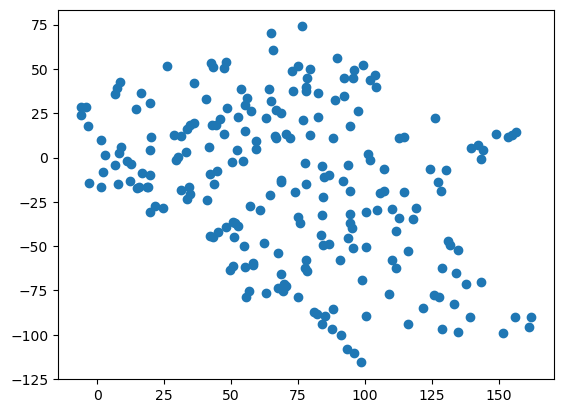

In [90]:
plt.scatter(local_cam_east, local_cam_north)

NameError: name 'gnss_gem2_match_eastings' is not defined

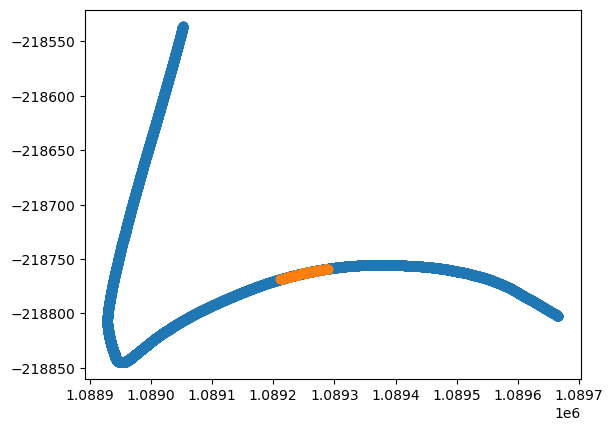

In [91]:
plt.scatter(gnssutm[0], gnssutm[1])
plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(gnss_gem2_match_eastings,gnss_gem2_match_northings)
plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings)


In [99]:
world_cam_east = local_cam_east + gnss_cam_match_eastings[0]
world_cam_north = local_cam_north + gnss_cam_match_northings[0]

In [100]:
world_cam_east[0]

1089229.567748258

In [101]:
world_gem2_east[0]

NameError: name 'world_gem2_east' is not defined

In [102]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200, label = "GEM2")
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100, label = "Magnaprobe")
plt.scatter(world_cam_east, world_cam_north, c = cameradata["AboveGroundAltitude"], label = "camera centres", cmap="Greens")
plt.legend()
plt.grid()

NameError: name 'world_gem2_east' is not defined

In [103]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)

In [104]:
cam_latlon = backtolatlon.transform(world_cam_east, world_cam_north)

In [105]:
cam_out = cameradata.copy()

In [106]:
cam_out["GPSLatitude"] = cam_latlon[0]

In [107]:
cam_out["GPSLongitude"] = cam_latlon[1]

In [108]:
cam_output_exiftool = "/mnt/documents/ANAFI_USA_data/AeN_Q1_2021_P4_10032021/driftcorrected-for-exiftool.csv"

In [109]:
cam_out.to_csv(cam_output_exiftool, index=False)

In [110]:
cam_out['GPSLatitude'][0] - cameradata["GPSLatitude"][0]

-6.536993168992922e-13

In [111]:
cam_out['GPSLatitude'][0]

79.77034549999935

In [112]:
cam_out_hag = cam_out.copy()

In [113]:
cam_out_hag["GPSAltitude"] = cam_out_hag["AboveGroundAltitude"]

In [114]:
cam_out_hag.drop(columns = ["AboveGroundAltitude"], inplace = True)

In [115]:
cam_output_exiftool_hag = "/mnt/documents/ANAFI_USA_data/AeN_Q1_2021_P4_10032021/driftcorrected-for-exiftool-HAG.csv"

In [116]:
cam_out_hag.to_csv(cam_output_exiftool_hag, index=False)